In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [3]:
# load dataset
df_AAPL = pd.read_csv('./datasets/AAPL.csv', header=0, index_col=0)
df_AAPL.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/11/2018,47.84,47.99,47.55,47.81,"18,308,460"
6/12/2018,47.85,48.15,47.79,48.07,"16,911,141"
6/13/2018,48.11,48.22,47.61,47.68,"21,638,393"
6/14/2018,47.89,47.89,47.56,47.70,"21,610,074"
6/15/2018,47.51,47.54,47.07,47.21,"61,719,160"


<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   object 
dtypes: float64(4), object(1)
memory usage: 59.0+ KB


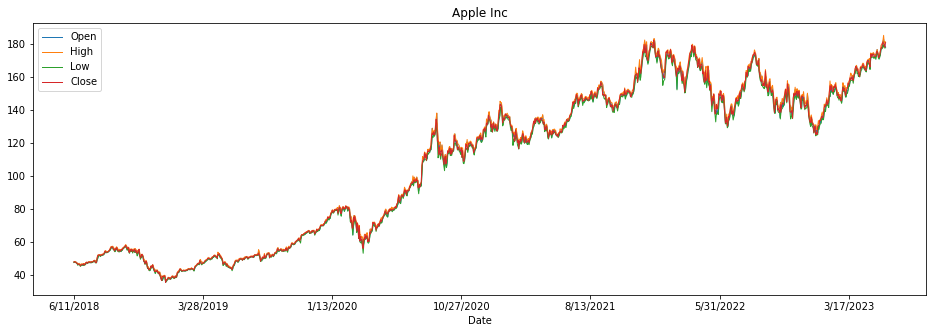

In [31]:
df_AAPL.info()
df_AAPL.plot(figsize=(16,5),lw=1, title="Apple Inc")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

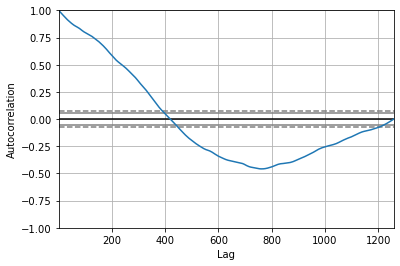

In [5]:
autocorrelation_plot(df_AAPL[["Open","High","Low","Close"]])

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7+ KB


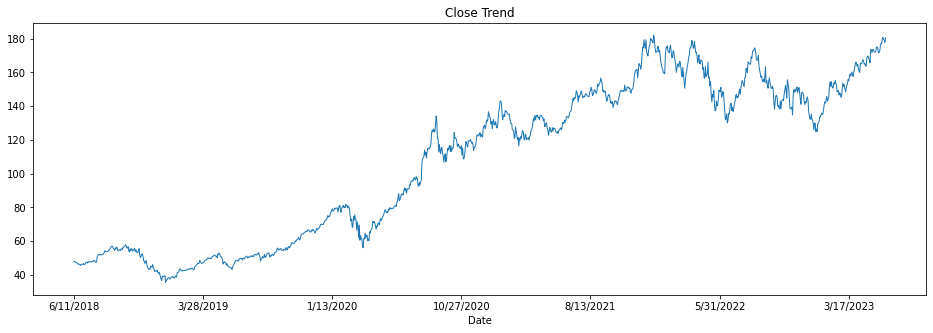

In [6]:
df_close = df_AAPL["Close"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Close Trend")
plt.show()

### Split data for train and test

In [8]:
# Split the data for train and test
df_train = df_close[:1228].copy()
df_test = df_close[1228:].copy()

In [9]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

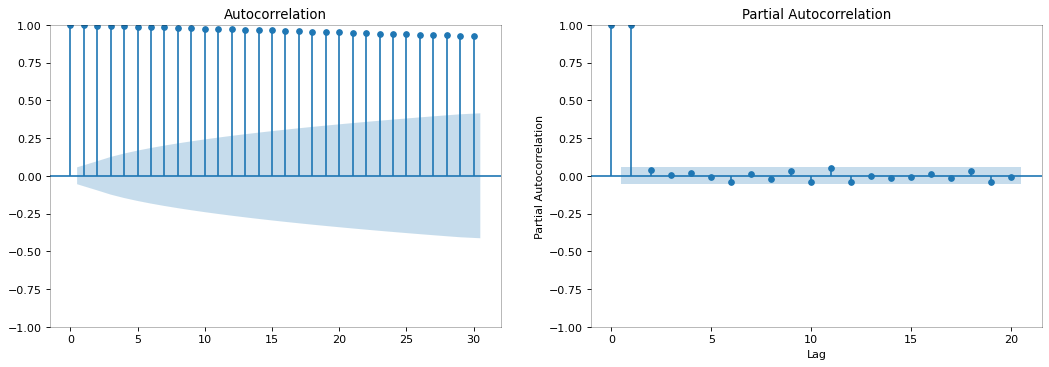

In [10]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [11]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [12]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -0.860497
p-value: 0.800703
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [13]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [14]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            5.544681
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -0.39000000000000057


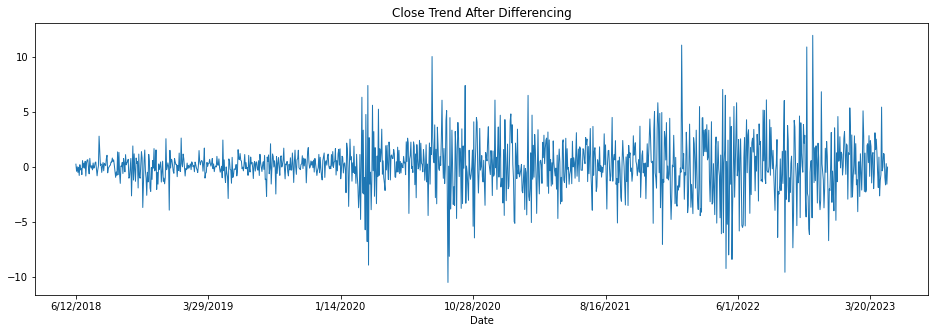

In [16]:
# Perform differencing
df_train_diff = df_train.diff().dropna()
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_train_diff[1]}" )
plt.show()

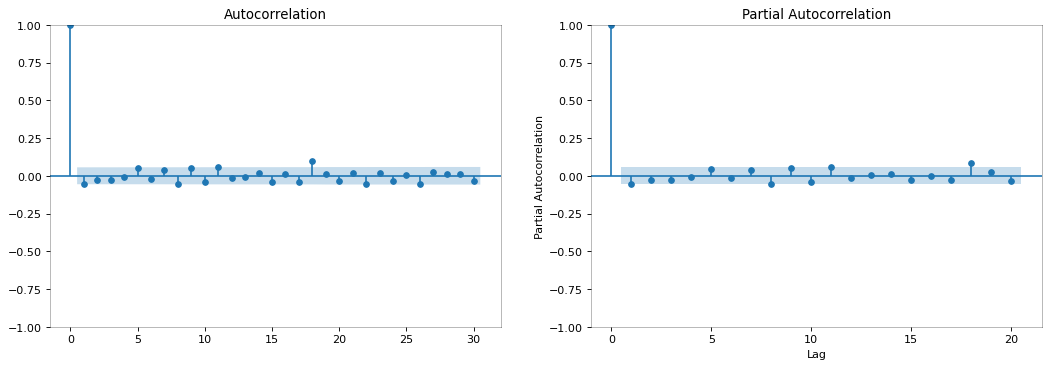

In [17]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [18]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [19]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=2, max_q=2,m=12,start_P=0,start_Q=0, 
                          max_P = 2, max_Q = 2,
                          seasonal=True,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6351.481, Time=0.32 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6018.576, Time=0.62 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6345.394, Time=0.34 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5848.143, Time=1.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=10.56 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.79 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5851.074, Time=0.87 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5848.976, Time=1.31 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5849.148, Time=2.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5847.836, Time=1.09 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=6018.660, Time=0.60 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=13.57 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=4.65 sec
 ARIMA(0,1,2)(2,1,0)[12]             : AIC

## Fit the ARIMA Model

In [20]:
model = ARIMA(df_train, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1228
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2767.514
Date:                Fri, 16 Jun 2023   AIC                           5539.027
Time:                        11:19:01   BIC                           5549.252
Sample:                             0   HQIC                          5542.874
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0578      0.021     -2.749      0.006      -0.099      -0.017
sigma2         5.3289      0.139     38.382      0.000       5.057       5.601
Ljung-Box (L1) (Q):                   0.00   Jarque-

## Make time series prediction

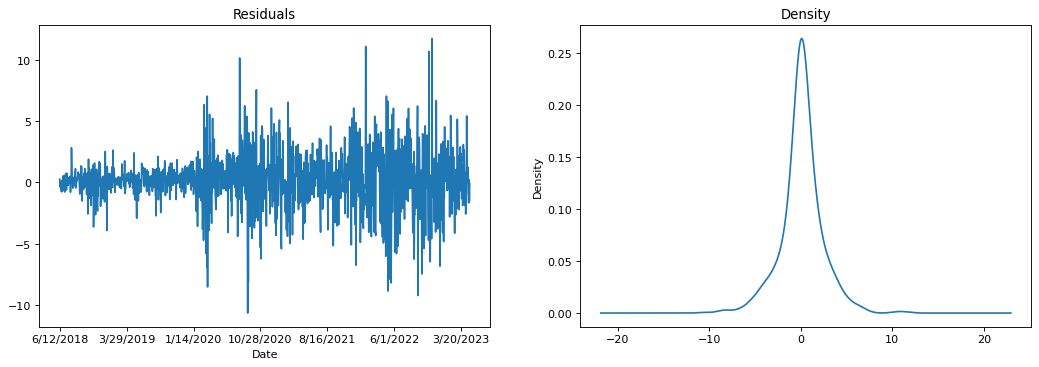

In [21]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

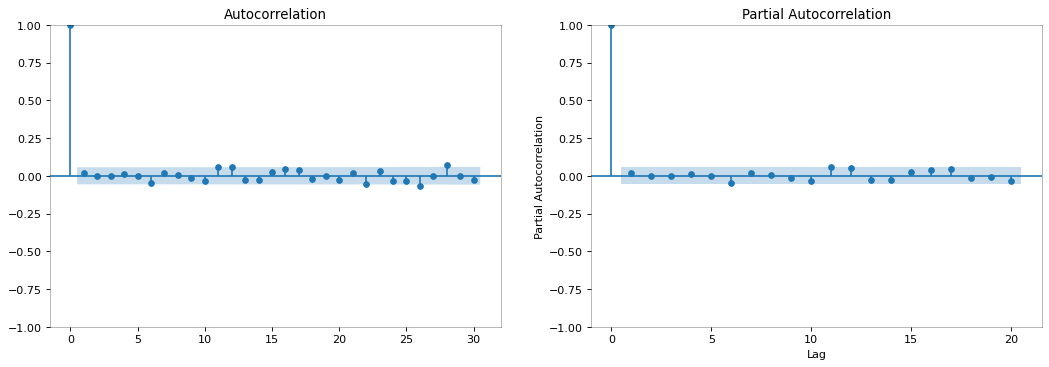

In [29]:
plot_correlation(residuals)

In [22]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [23]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Close
Date,,
4/27/2023,163.765751,168.41
4/28/2023,163.765751,169.68
5/1/2023,163.765751,169.59
5/2/2023,163.765751,168.54
5/3/2023,163.765751,167.45
5/4/2023,163.765751,165.79
5/5/2023,163.765751,173.57
5/8/2023,163.765751,173.50
5/9/2023,163.765751,171.77


<AxesSubplot:xlabel='Date'>

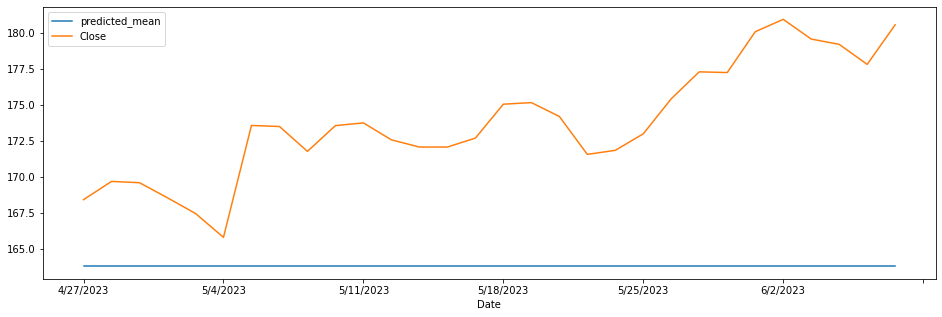

In [24]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [25]:
train = df_close[:1228].copy()
test = df_close[1228:].copy()

In [26]:
final_model = SARIMAX(train,order=(0,1,1),seasonal_order=(2,1,0,12)) # Best model:  ARIMA(0,1,1)(2,1,0)[12] 
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41625D+00    |proj g|=  1.03202D-01

At iterate    5    f=  2.37778D+00    |proj g|=  7.32454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   4.072D-06   2.378D+00
  F =   2.3777834926027079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                          

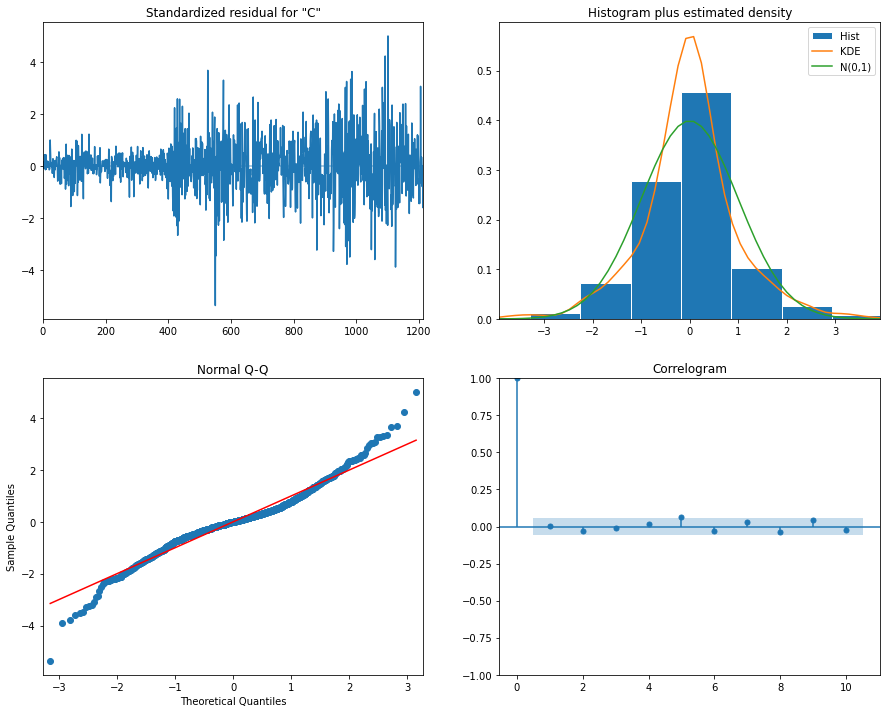

In [27]:
result.plot_diagnostics(figsize=(15, 12));

In [28]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# Best model:  ARIMA(0,1,1)(2,1,0)[12] 
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)(2,1,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(0,1,1)(2,1,0,12) Predictions",Close
Date,,
4/27/2023,162.872033,168.41
4/28/2023,163.498024,169.68
5/1/2023,163.901540,169.59
5/2/2023,162.835504,168.54
5/3/2023,164.501034,167.45
5/4/2023,166.166224,165.79
5/5/2023,167.468052,173.57
5/8/2023,168.562116,173.50
5/9/2023,167.544940,171.77


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

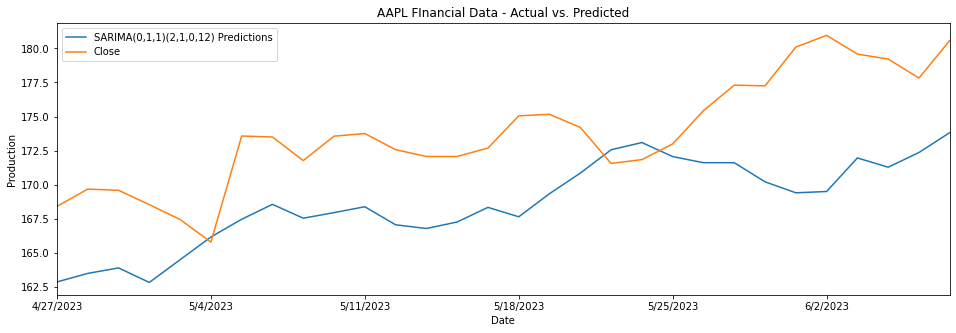

In [30]:
title = 'AAPL FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)